# Tutorial 3.2: The Quantum Approximate Optimization Algorithm (QAOA)

The [Quantum Approximate Optimization Algorithm (QAOA)](https://en.wikipedia.org/wiki/Quantum_algorithm#QAOA), introduced by Farhi et al. in 2014, is a variational hybrid quantum-classical algorithm designed to find approximate solutions to [combinatorial optimization problems](https://en.wikipedia.org/wiki/Combinatorial_optimization). It works by alternating between two parameterized quantum operators: one encoding the problem Hamiltonian (representing the cost function to be minimized) and one encoding the mixer Hamiltonian (which explores the solution space). A classical optimizer iteratively updates the parameters to minimize the expectation value of the cost function. Due to its hybrid structure, QAOA is particularly suited for NISQ-era devices, where quantum coherence times are limited but can still be leveraged to gain computational advantages.


In [ ]:
#Install required packages to run the code in this notebook
#!pip install qiskit==2.2.1 qiskit-aer==0.17.2 qiskit-optimization==0.7.0 qiskit-algorithms==0.4.0
#!pip install scipy

**Table of Contents**

&nbsp;&nbsp;[Introduction](#Introduction)   
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; [Optimization with quantum computers](#s1-1)  
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; [QUBO problems and the Ising model](#s1-2)  
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; [The adiabatic theorem](#s1-3)  
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; [The QAOA](#s1-4)  
&nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; [The QAOA and the MaxCut problem](#s1-4)  
&nbsp;&nbsp;[Exercises](#ex)   
&nbsp;&nbsp;[Suggested readings](#bib)

<a name="Introduction"></a>
## Introduction

[Optimization](https://en.wikipedia.org/wiki/Mathematical_optimization) is one of the oldest branches of mathematics and formalizes the intuitive procedure of selecting, according to given criteria, the best element among a set of possible alternatives. Important optimization problems arise both from purely theoretical considerations (e.g., in the calculus of variations, differential geometry, and rational mechanics) and from applications (e.g., logistics, machine learning, quantitative finance). These problems are often so complex that they cannot be solved exactly or analytically, except in extremely simple cases. In this sense, the computer is an indispensable tool for working effectively in these fields. The trouble is that most of the most interesting problems do not admit exact solutions even by computer—or, worse, they do not even admit approximate solutions that a computer can determine within reasonable times and with an acceptable error rate. For this reason, since quantum computing was formalized in the first half of the 1980s, optimization problems have been among the first topics to be studied.  

In this notebook, we will examine one of the many available techniques for solving [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) optimization problems using a [hybrid approach](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver), in which part of the solution is computed by a quantum device and the remaining part by a classical device. This aims to balance the difficulties classical devices face in handling such problems with the potential of quantum computation, which is itself still limited by the early-stage nature of NISQ technology.


<a name="s1-1"></a>
## Optimization with quantum computers

Consider as a guiding example a linear optimization problem with constraints where you are asked to minimize the function $f(x,y)=3x+4y$ subject to $x,y$ are positive integers and $x+2y\leq 8$. We can classically solve this simple problem by direct enumeration.

In [ ]:
# Solution by enumeration of a simple constrained optimization problem
# With a rough estimation of the computational resources required
# Objective function (linear): f(x, y) = 3x + 4y
# Constraints: x > 0, y > 0, x + 2y <= 8, x and y are integers

import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def objective_function(x, y):
    return 3 * x + 4 * y


def is_feasible(x, y):
    return (x + 2 * y <= 8) and (x > 0) and (y > 0) and (float(x).is_integer() and float(y).is_integer())

In [ ]:
best_solution = None
best_value = float('-inf')
iterations = 0

for x in range(0, 100):
    for y in range(0, 100):
        iterations += 1
        if is_feasible(x, y):
            value = objective_function(x, y)
            if value > best_value:
                best_value = value
                best_solution = (x, y)

print(f"solution: x = {best_solution[0]}, y = {best_solution[1]}")
print(f"maximum value: {best_value}")
print(f"number of iterations: {iterations}")

# Estimate of the number of bits needed to represent x and y
bits_x = int(math.log2(100))
bits_y = int(math.log2(100))
total_bits = bits_x + bits_y

# Estimate of the number of classical logical gates needed to solve the problem
gates_objective = 2 * (bits_x + bits_y)
gates_constraint = 2 * (bits_x + bits_y)
gates_total = gates_objective + gates_constraint

print("bits:", total_bits)
print("classical gates:", gates_total)

solution: x = 6, y = 1
maximum value: 22
number of iterations: 10000
bits: 12
classical gates: 48


Suppose now that you want to carry out the same task on a quantum device, what kind of resources would be used? The following code shows that even in this simple case the number of qubits and gates saturates the resources available on current NISQ devices.

In [ ]:
# Solution of the same problem on a quantum device (it can take a while...)

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler

# Problem definition
qp = QuadraticProgram()
qp.integer_var(name="x", lowerbound=1, upperbound=8)
qp.integer_var(name="y", lowerbound=1, upperbound=3)
qp.maximize(linear={"x": 3, "y": 4})
qp.linear_constraint(linear={"x": 1, "y": 2}, sense="LE", rhs=8)

# Convert to "qubit form" (for diagnostic)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

# Solve
sampler = StatevectorSampler()
meo = MinimumEigenOptimizer(QAOA(sampler=sampler, optimizer=COBYLA(maxiter=10)))
result = meo.solve(qp)

print(result.prettyprint())
print("approximate number of quantum gates", len(qubitOp))
print("approximate number of qubits:", getattr(qubitOp, "num_qubits", None))


objective function value: 22.0
variable values: x=6.0, y=1.0
status: SUCCESS
approximate number of quantum gates 36
approximate number of qubits: 8


Now... is this feasible? It make sense to use a quantum computer in this way? In the following parts we will try to answer this kind of questions and show that with "custom" constructions (i.e., the non-out of the box version of the QAOA discussed above) we could hope for some advantage, or, at least, to gain some insight that would be precluded otherwise.


The following code shows a gradient-ascent strategy to solve the problem discussed above, to complement the enumerative strategy.

In [ ]:
# Solution via gradient ascent

import numpy as np

def project_to_triangle(x, y):
    # First, clip to non-negatives
    x = max(x, 1.0)
    y = max(y, 1.0)
    # If already satisfies x + 2y <= 8, we're done
    if x + 2*y <= 8 + 1e-12:
        return x, y
    # Project (x,y) onto the line x + 2y = 8 in Euclidean distance
    # Solve min ||(x',y')-(x,y)||^2 s.t. x' + 2y' = 8
    # Lagrange gives:
    #   x' = x - (1/5)*(x + 2y - 8)
    #   y' = y - (2/5)*(x + 2y - 8)
    t = (x + 2*y - 8.0)
    x_p = x - (1.0/5.0)*t
    y_p = y - (2.0/5.0)*t
    # Ensure non-negativity after projecting to the line:
    x_p = max(x_p, 1.0)
    y_p = max(y_p, 1.0)
    # If clipping broke the line constraint slightly, snap back to the nearest feasible corner on that edge
    if x_p + 2*y_p > 8 + 1e-10:
        # Move along the edge direction to satisfy x + 2y = 8
        # Prefer reducing y if needed (keeps us on or inside the set)
        y_p = min(y_p, (8 - x_p)/2.0)
    return x_p, y_p


def projected_gradient_ascent(start, lr=0.2, iters=200, tol=1e-9):
    x, y = start
    # Constant gradient of the linear objective:
    g = np.array([3.0, 4.0])
    last_val = objective_function(x, y)
    for _ in range(iters):
        x, y = x + lr*g[0], y + lr*g[1]
        x, y = project_to_triangle(x, y)
        val = objective_function(x, y)
        if abs(val - last_val) < tol:
            break
        last_val = val
    return x, y, val

In [ ]:
# start anywhere in/near the set
x0_relaxed = (0.0, 0.0)
xr, yr, vr = projected_gradient_ascent(x0_relaxed, lr=0.3, iters=1000)

print("Relaxed (continuous) optimum by projected gradient ascent:")
print(f"  (x, y) ≈ ({xr:.6f}, {yr:.6f}),  f ≈ {vr:.6f}")

# What the theory says for a linear objective --------
# For the relaxed problem, the maximizer lies at an extreme point of the triangle.
# Check the corners: (0,0), (8,0), (0,4) -> best is (8,0) with f=24.
print("\nExtreme points check (relaxed):")
for (xx, yy) in [(0,0), (8,0), (0,4)]:
    print(f"  (x, y) = ({xx}, {yy}), f = {objective_function(xx, yy)}")

Relaxed (continuous) optimum by projected gradient ascent:
  (x, y) ≈ (9.600000, -0.800000),  f ≈ 25.600000

Extreme points check (relaxed):
  (x, y) = (0, 0), f = 0
  (x, y) = (8, 0), f = 24
  (x, y) = (0, 4), f = 16


Thw corresponding quantum version of this strategy is based on [parameter shift rules](https://arxiv.org/abs/2107.12390) and we will dedicate a separated project about this topic. For the moment you can check the previous gradient ascent method against the following code.

In [ ]:
# Solution with out-of-the box QAOA and parameter-shift rules

from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.optimizers import COBYLA

def energy(theta):
    res = estimator.run(pubs=[(ansatz, qubitOp, theta)]).result()
    return float(res[0].data.evs)

def energy_grad(theta):
    # ParamShiftEstimatorGradient
    gres = grad.run(
        circuits=[ansatz],
        observables=[qubitOp],
        parameter_values=[theta],
    ).result()
    return gres.gradients[0]


# Build the QAOA ansatz for the cost operator qubitOp
p = 1
ansatz = QAOAAnsatz(cost_operator=qubitOp, reps=p)

# Estimator + parameter-shift gradient
estimator = StatevectorEstimator()
grad = ParamShiftEstimatorGradient(estimator)

# Simple gradient descent on the angles (for QAOA we minimize energy, so we descend)
import numpy as np
theta = np.zeros(ansatz.num_parameters, dtype=float)
lr = 0.2
maxiter = 200
tol = 1e-8
prev = energy(theta)
for _ in range(maxiter):
    g = energy_grad(theta)
    theta = theta - lr * g
    val = energy(theta)
    if abs(prev - val) < tol:
        break
    prev = val
print("Trained energy:", prev)
print("Num params:", ansatz.num_parameters)

# Use the trained angles as QAOA's initial point and let the optimizer do *zero* steps.
# This makes QAOA evaluate exactly at `theta`, and `MinimumEigenOptimizer` will decode back to (x,y).
sampler = StatevectorSampler()
qaoa = QAOA(
    sampler=sampler,
    optimizer=COBYLA(maxiter=0),
    reps=p,
    initial_point=theta.tolist()
)
meo = MinimumEigenOptimizer(qaoa)
result = meo.solve(qp)
print(result.prettyprint())
print("approximate number of quantum gates (Pauli terms in H):", len(qubitOp))
print("approximate number of qubits:", getattr(qubitOp, "num_qubits", None))

Trained energy: 6.245004513516506e-16
Num params: 2
objective function value: 22.0
variable values: x=6.0, y=1.0
status: SUCCESS
approximate number of quantum gates (Pauli terms in H): 36
approximate number of qubits: 8


<a name="s1-2"></a>
## QUBO problems and the Ising model

In the field of combinatorial optimization problems, where typically the feasible space is $\Omega \subset \mathbb{Z}^n$, one can restrict to the case of binary variables. In fact, if $x \in \Omega$ is a vector with integer components $x = (x_1, \dots, x_n) \in \mathbb{Z}^n$, by representing each component $x_i \in \mathbb{Z}$ in base two, and writing $z_i = (x_i)_2$ for each $i = 1, \dots, n$, we move from $x$ to a binary string $z = (x)_2$ with components $z = (z_1, \dots, z_n)$. For simplicity of notation, we will denote a binary string $z$ by the juxtaposition of symbols $z = z_1z_2 \dots z_n$. Clearly, $z \in \{0,1\}^N$ is a sequence of $N > n$ bits. In this context, the objective function $f : \{0,1\}^N \to \mathbb{R}$ can take an exponential (in $N$) number of values $f(z)$, one for each binary assignment of the bits in $z$. Moreover, the incremental ratio  
$$
\Delta_h f = \frac{1}{h}(f(z + h) - f(z))
$$  
is not well-defined for every $h \in \mathbb{R}$, and therefore classical techniques based on gradient analysis cannot be applied; a detailed study of the cost function is necessary on a case-by-case basis. Classically, several analysis techniques exist, essentially based on: enumeration (when possible, as discussed above), variable [relaxation](https://en.wikipedia.org/wiki/Relaxation_(approximation)), approximation of $f$ (e.g., through [Taylor series](https://en.wikipedia.org/wiki/Taylor_series)), [stochastic methods](https://en.wikipedia.org/wiki/Stochastic_optimization), or combinations of the above. As we shall see, in a certain sense, quantum optimization algorithms encompass all these approximate techniques within a single computational framework.

The simplest case one can begin to analyze is given by the so-called [QUBO problems](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) (Quadratic Unconstrained Binary Optimization Problems), where $\Omega = \{0,1\}^N$ and the cost function  

$$
f(z) = \langle z | \mathbf{a} z \rangle + \langle b | z \rangle + c
$$  

is a quadratic form determined by a weight matrix $\mathbf{a} = (a_{ij}) \in \mathbb{R}^{N \times N}$ and two column vectors $b, c \in \mathbb{R}^N$. It is not difficult to notice (cf. Exercise 3) that one can set $c = 0$ without loss of generality, while in general $b \ne 0$ and $\mathbf{a}$ is considered upper triangular (equivalently, symmetric and non-degenerate). Explicitly,  
$$
f(z) = \sum_{i,j} a_{ij} z_i z_j + \sum_i b_i z_i \,.
$$
Since we are dealing with binary variables, $f$ can be directly computed on classical devices, but the same cannot be done on quantum devices, and we need to suitably translate the problem in the quantum setting.

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) allows mapping a QUBO problem into one that a quantum computer can solve (Hamiltonian simulation). The first step of this transformation consists in considering a one-to-one mapping, where the use of superscripts is introduced for convenience (i.e., $z_i = z^{(i)}$):
$$
z^{(i)} \to z'^{(i)} = 2z^{(i)} - 1
$$
for each $i = 1, \dots, n$, which transforms the bits $z_i = z^{(i)}$ into signed variables $z'^{(i)} \in \{\pm 1\}$. Since the values $\pm 1$ correspond precisely to the eigenvalues of the Pauli matrices, and every measurement at the end of a quantum computation returns the eigenvalues corresponding to the observables that generate the unitaries used in the evolution of the computation according to the Born rule, the ideal mapping is therefore to associate each variable $z$ with a set $\sigma$ of Pauli matrices.

At this point, the method for determining the Pauli observables becomes clear: the objective function $f(z')$ corresponds to the Hamiltonian of a spin system, where the mixed interaction terms are determined by a Pauli matrix, for example  
$$
\boldsymbol{\sigma}_z^{(i)} =
\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
$$  
and the external field term by a Pauli matrix that does not commute with the previous ones, for example  
$$
\boldsymbol{\sigma}_x^{(i)} =
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\,.
$$  
With this notation, the quantum objective function is  
$$
f(\sigma) = \sum_{ij} a_{ij} \boldsymbol{\sigma}_z^{(i)} \otimes \boldsymbol{\sigma}_z^{(j)} + \sum_i b_i \boldsymbol{\sigma}_x^{(i)}\,,
$$
which represents the Hamiltonian observable of a spin (qubit) system. More general forms, where multi-local interactions appear (e.g., three-body or four-body interactions), are possible, as well as cases where the external field term involves multiple Pauli operators — however, these lie beyond the scope of QUBO problems.


In [ ]:
# QUBO to Ising mapping

from itertools import product


def qubo_to_ising(Q_dict, assume_upper_triangle=True):
    """
    Convert a QUBO dictionary to Ising parameters (J, h, offset).
    """
    if not Q_dict:
        return {}, {}, 0.0

    n = 1 + max(max(i, j) for (i, j) in Q_dict.keys())
    Q = np.zeros((n, n), dtype=float)
    if assume_upper_triangle:
        for (i, j), val in Q_dict.items():
            if i == j:
                Q[i, i] += val
            elif i < j:
                # split evenly to reproduce sum_{i<=j} q_ij z_i z_j
                Q[i, j] += val / 2.0
                Q[j, i] += val / 2.0
            else:
                # treat lower-tri as upper-tri
                Q[j, i] += val / 2.0
                Q[i, j] += val / 2.0
    else:
        # symmetrize since only the symmetric part contributes
        for (i, j), val in Q_dict.items():
            Q[i, j] += val
        Q = 0.5 * (Q + Q.T)
    one = np.ones(n)
    # Couplings J for i<j
    J = {}
    for i in range(n):
        for j in range(i + 1, n):
            if abs(Q[i, j]) > 0:
                J[(i, j)] = 0.5 * Q[i, j]
    # Linear fields h
    h_vec = 0.5 * (Q @ one)
    h = {i: float(h_vec[i]) for i in range(n) if abs(h_vec[i]) > 0}
    # Constant offset
    offset = 0.25 * (np.trace(Q) + float(one @ Q @ one))
    offset = float(offset)
    return h, J, offset


def qubo_energy(Q_dict, z, assume_upper_triangle=True):
    """Compute E_QUBO(z) honoring the upper-triangular convention if selected."""
    n = len(z)
    E = 0.0
    if assume_upper_triangle:
        for (i, j), val in Q_dict.items():
            if i <= j:
                E += val * z[i] * z[j]
            else:
                # lower-tri key as upper-tri
                E += val * z[j] * z[i]
    else:
        for (i, j), val in Q_dict.items():
            E += val * z[i] * z[j]
    return float(E)


def ising_energy(h, J, offset, s):
    """E_Ising(s) = ∑_{i<j} J_ij s_i s_j + ∑_i h_i s_i + offset"""
    E = offset
    for i, hi in h.items():
        E += hi * s[i]
    for (i, j), Jij in J.items():
        E += Jij * s[i] * s[j]
    return float(E)


def format_hamiltonian(h, J, offset):
    parts = []
    for (i, j), val in sorted(J.items()):
        parts.append(f"({val})*σ_z^{i}σ_z^{j}")
    for i, val in sorted(h.items()):
        parts.append(f"({val})*σ_z^{i}")
    if abs(offset) > 0:
        parts.append(f"({offset})*I")
    return " + ".join(parts) if parts else f"({offset})*I"

In [ ]:
qubo_problem = {
    (0, 0): -1,
    (1, 1): -1,
    (0, 1):  2,
}
h, J, offset = qubo_to_ising(qubo_problem, assume_upper_triangle=True)
H_str = format_hamiltonian(h, J, offset)

print("Ising fields h:", h)
print("Ising couplings J:", J)
print("Offset (constant):", offset)
print("Hamiltonian H:", H_str)
# Consistency check
n = 1 + max(max(i, j) for (i, j) in qubo_problem)
ok = True
for z in product([0, 1], repeat=n):
    s = [2*zi - 1 for zi in z]
    EQ = qubo_energy(qubo_problem, z, assume_upper_triangle=True)
    EI = ising_energy(h, J, offset, s)
    if abs(EQ - EI) > 1e-9:
        ok = False
        print("Mismatch for z =", z, " -> E_QUBO:", EQ, "E_Ising:", EI)
        break
print("Energy mapping check:", "OK" if ok else "FAILED")

Ising fields h: {}
Ising couplings J: {(0, 1): np.float64(0.5)}
Offset (constant): -0.5
Hamiltonian H: (0.5)*σ_z^0σ_z^1 + (-0.5)*I
Energy mapping check: OK


<a name="s1-3"></a>
## The adiabatic theorem

We have seen that, to solve a combinatorial optimization problem (of the QUBO type), the objective function $f$ is written in terms of bits $f = f(z)$, then transformed into signed coordinates $f = f(z')$ with $z' = 2z - 1$, and each variable is associated with a Pauli matrix according to the Ising model $f = f(\sigma)$. Once this encoding step is completed, the optimization problem must be concretely solved on a quantum computer — that is, we need to describe how the objective function, initialized in a certain state $|\psi_0\rangle$, can be evolved to the state $|\psi^*\rangle$ corresponding to the minimum of the Ising Hamiltonian.   Indeed, by knowing $|\psi^*\rangle$, one can go backwards by associating each of its components with a signed variable, and therefore recover the corresponding $i$-th bit of the solution. In this way, the minimum-energy configuration for $f(\sigma)$ determines the solution of the QUBO optimization problem, $f(z^*) = \min_\Omega f(z)$. this pipeline can be carried out simply using out-of-the box methods as discussed in the previous sections, but it can also be extremely usefull to build the QAOA from scratch in order to calibrate it, extend its capabilities etc...


The way to reach the minimum eigenstate of $f(\sigma)$ using a quantum computer is through an [adiabatic process](https://en.wikipedia.org/wiki/Adiabatic_theorem): one initializes $f = f(\sigma)$ in $\sigma$, and then considers a small perturbation of $f$ for an evolution time $T \gg 1$. If $T$ is sufficiently large and the perturbation remains sufficiently close (as a Hamiltonian) to $f$ during the evolution, then the gradual change in conditions allows the system to adapt its configuration. As a result, the probability density corresponding to the measurement of the evolving system is modified by the process in a controlled manner.


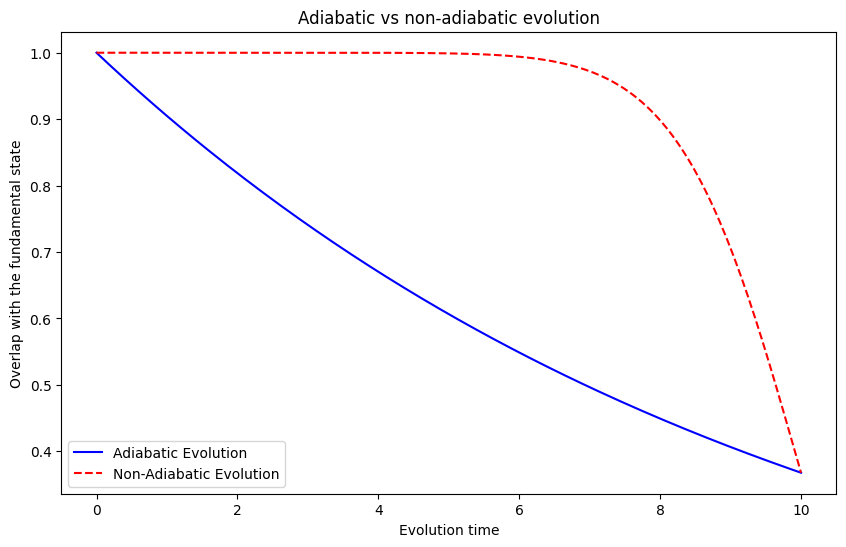

In [ ]:
# Example of an adiabatic vs a non-adiabatic evolution

import matplotlib.pyplot as plt

def hamiltonian(t, T, J=1.0):
    h_t = 1.0 - t / T
    return h_t, J

def adiabatic_evolution(T, steps=100):
    overlaps = []
    for t in np.linspace(0, T, steps):
        h_t, J = hamiltonian(t, T)
        overlap = np.exp(-t / T)
        overlaps.append(overlap)
    return overlaps

def non_adiabatic_evolution(T, steps=100):
    overlaps = []
    for t in np.linspace(0, T, steps):
        h_t, J = hamiltonian(t, T)
        overlap = np.exp(- (t / T) ** 10)
        overlaps.append(overlap)
    return overlaps

T = 10
steps = 200

# Overlaps
adiabatic_overlaps = adiabatic_evolution(T, steps)
non_adiabatic_overlaps = non_adiabatic_evolution(T, steps)

# Plots
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, steps), adiabatic_overlaps, label="Adiabatic Evolution", color='b')
plt.plot(np.linspace(0, T, steps), non_adiabatic_overlaps, label="Non-Adiabatic Evolution", color='r', linestyle='--')
plt.xlabel("Evolution time")
plt.ylabel("Overlap with the fundamental state")
plt.title("Adiabatic vs non-adiabatic evolution")
plt.legend()
plt.show()

Let us suppose we prepare a quantum system in the ground state $|\psi_0\rangle$ of a given Hamiltonian $H$ (that is, $|\psi_0\rangle$ is the eigenstate that minimizes $H$), and then we gradually modify $H$ over time. If the change is sufficiently slow, then the system remains in the instantaneous ground state with high probability.  

The time-dependent Hamiltonian is described by a family of self-adjoint operators $\{H(t)\}_{t \in [0,T]}$ on the Hilbert space of the quantum system under consideration. The dynamics of the system prepared in the ground state $|\psi_0\rangle$ is governed by the solution of the Schrödinger equation  
$$
i\hbar \frac{d}{dt} |\psi(t)\rangle = H(t)|\psi(t)\rangle \quad t \in [0, T],
$$  
with initial condition $|\psi(0)\rangle = |\psi_0\rangle$.  

We can reparametrize the time-dependent Hamiltonian as $\tilde{H}(s) := H(Ts)$ with $s \in [0, 1]$. For each $s \in [0, 1]$, we have the following [eigenvalue problem](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors):  

$$
\tilde{H}(s)|l s\rangle = E_l(s)|l s\rangle,
$$  

where $E_0(s)$ is the minimum of the spectrum of $\tilde{H}(s)$ and $|0 s\rangle$ is the corresponding eigenvector, i.e., the ground state. We assume that the initial state is non-degenerate.  

*Adiabatic Theorem.* If $\lambda(s) := E_1(s) - E_0(s) > 0$ for every $s \in [0, 1]$, then:  
$$
\lim_{T \to +\infty} |\langle 0 1|\psi(T)\rangle| = 1,
$$  
where $|\psi(T)\rangle$ is the solution of the Schrödinger equation described above, with the initial condition $|\psi(0)\rangle = |0 0\rangle$, evaluated at $t = T$.  

The existence of a non-zero spectral gap $\lambda$ ensures that the state of the evolving system remains in the ground state of $H(t)$ for every $t \in [0, T]$, provided that the evolution time is sufficiently long.  

*Remark.* To estimate how large $T$ must be so that the probability of remaining in the ground state is acceptable, the following approximate bound can be used, although more refined adiabatic conditions exist:  
$$
T \gg \frac{\max_s \left\| \frac{d}{ds}\tilde{H}(s) \right\|_{\text{op}}}{[\min_s \lambda(s)]^2},
$$  
where $\| \cdot \|_{\text{op}}$ denotes the [operator norm](https://en.wikipedia.org/wiki/Operator_norm).

The general structure of an adiabatic quantum computation is therefore as follows:

- A quantum system is prepared in the known ground state of an initial Hamiltonian $H_I$ such that $[H_I, f(\sigma)] \neq 0$, meaning it [does not commute](https://en.wikipedia.org/wiki/Commutator) with the Ising Hamiltonian.
- A time-dependent variation of the Hamiltonian from $H_I$ to $f(\sigma)$ is implemented as  
  $$H(t) = (1 - s(t))H_I + s(t)f(\sigma)$$  
  with $t \in [0, T]$, where $T$ satisfies the conditions of the adiabatic theorem.  
  Here, $s : [0, T] \to [0, 1]$ is a smooth, monotonically increasing function such that $s(0) = 0$ and $s(T) = 1$, and $f(\sigma)$ is the Hamiltonian representing the optimization problem.
- A measurement process of the evolved quantum system.

The problem to be solved is encoded in $f(\sigma)$, and its ground state represents the solution. According to the adiabatic theorem, the final measurement process is performed on the ground state of $f$ with high probability.

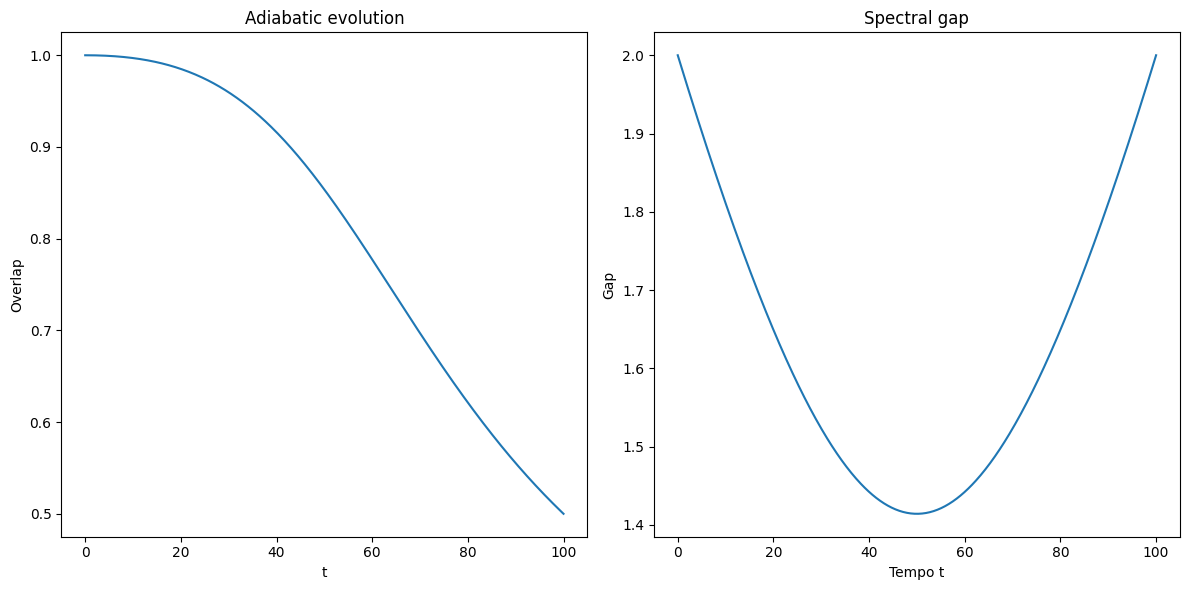

In [ ]:
# Example of an adiabatic simulation

from scipy.linalg import expm
from scipy.integrate import solve_ivp

hbar = 1.0
T = 100.0
steps = 500
n_points = 100

def H0():
    return np.array([[1, 0], [0, -1]])

def H1():
    return np.array([[0, 1], [1, 0]])

def H_t(t, T):
    s = t / T
    return (1 - s) * H0() + s * H1()

def instantaneous_eigenstate(t, T):
    H = H_t(t, T)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    ground_state = eigenvectors[:, 0]
    gap = eigenvalues[1] - eigenvalues[0]
    return eigenvalues[0], ground_state, gap

def schrodinger_eq(t, psi, T):
    H = H_t(t, T)
    return -1j / hbar * H @ psi

_, psi0, _ = instantaneous_eigenstate(0, T)
times = np.linspace(0, T, steps)
sol = solve_ivp(lambda t, psi: schrodinger_eq(t, psi, T), [0, T], psi0, t_eval=times, vectorized=True)
evolved_states = sol.y.T

overlaps = []
spectral_gaps = []
for t_idx, t in enumerate(times):
    _, ground_state, gap = instantaneous_eigenstate(t, T)
    spectral_gaps.append(gap)
    overlaps.append(np.abs(np.vdot(ground_state, evolved_states[t_idx])) ** 2)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(times, overlaps)
plt.xlabel("t")
plt.ylabel("Overlap")
plt.title("Adiabatic evolution")

plt.subplot(1, 2, 2)
plt.plot(times, spectral_gaps)
plt.xlabel("Tempo t")
plt.ylabel("Gap")
plt.title("Spectral gap")

plt.tight_layout()
plt.show()

<a name="s1-4"></a>
## The QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is one of the possible quantum algorithms that implement adiabatic evolution to solve QUBO problems. Like all quantum algorithms, it is described by two main components:

- A set of unitary operators (quantum gates);
- Rules for combining the selected unitary operators (the quantum circuit).

As we have seen, the relevant unitary operators are those associated with the Pauli observables in the Ising Hamiltonian $f(\sigma)$, while the multiplication rules are determined by the adiabatic theorem.  

In this section, for consistency with the notation used in [parameterized quantum circuits](https://en.wikipedia.org/wiki/Quantum_circuit), the role of the evolution time will be represented by the sum of two angular parameters — one for each term in the Ising Hamiltonian.

Given a number of layers $p \geq 1$, together with $p$ angles $\gamma_k \in (0, 2\pi]$ and $p$ angles $\beta_k \in (0, \pi]$, the QAOA operates as follows:

- A basis encoding $z \to |z\rangle$ is chosen, and an initial state $|\psi_0\rangle$ is prepared as a uniform superposition  
  $$|\psi_0\rangle = \frac{1}{\sqrt{2^N}} \sum_z |z\rangle.$$
- The function $f(z)$ is mapped to $f(\sigma)$ by promoting each binary variable to a Pauli gate $\boldsymbol{\sigma}_z^{(i)}$. Then, for each integer $k = 1, \dots, p$, the following unitary operator is defined as a rotation  
  $$U_f(\gamma_k) = e^{-i \gamma_k f(\sigma)},$$  
  which is a product of $m$ terms.
- For each $k = 1, \dots, p$, a mixing operator $H_I$ is chosen that does not commute with $U_f$. In this case, another rotation is used:  
  $$H_I(\beta_k) = e^{-i \beta_k \sum_{j=1}^n \boldsymbol{\sigma}_x^{(j)}},$$  
  defined as a product of $N$ terms, each of which is a Pauli $\boldsymbol{\sigma}_x$ gate with rotation angle $\beta_k$.
- The evolved state is defined as  
  $$|\gamma \beta\rangle := H_I(\beta_p) U_f(\gamma_p) \prod_{i=1}^{p-1} [H_I(\beta_{p-i}) U_f(\gamma_{p-i})] |\psi_0\rangle,$$  
  and the expected value is computed as  
  $$F_p(\gamma, \beta) := \langle \gamma \beta | f(\sigma) | \gamma \beta \rangle.$$
- Finally, to improve the approximation of the solution, $F_p$ can be passed to a classical optimizer to obtain an updated set of parameters $\gamma^*, \beta^*$, and the process is repeated from the previous steps, increasing the number of layers $p \to p + 1$.


<a name="s1-5"></a>
## The QAOA and the MaxCut problem

As an interesting application of the QAOA on an [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) problem, let us consider the [maximum cut problem in a graph](https://en.wikipedia.org/wiki/Maximum_cut) (MaxCut). Consider a graph $(V, E)$ with $n$ vertices (nodes) $v_i \in V$ and $m \leq \frac{n(n-1)}{2}$ undirected edges $\{i, j\} \in E$. Recall that a *cut* in $\Gamma$ is a partition of $V$ into two sets $S$ and $V - S$ such that the set of edges $E$ has a subset $E_\mathrm{cut}$ of the form  
$$
E_\mathrm{cut} = \{ \{i, j\} : v_i \in S, \, v_j \in V - S \}.
$$  
A *maximum cut*, or *MaxCut*, is a cut with a maximal $E_\mathrm{cut}$. The MaxCut problem can be extended to graphs with weighted edges; in that case, it is referred to as the *weighted MaxCut* problem, and the general cost function is:  
$$
f(z) = \sum_{i<j} w_{ij}(1 - z_i z_j),
$$  
where $w_{ij} = w_{ji} > 0$ is the weight associated with the edge $\{i, j\}$ connecting node $v_i$ and node $v_j$, and $z_i = 1$ when $v_i \in S$, $z_i = 0$ otherwise, for ${i \in \{1, \dots, n\}}$.  

Clearly, MaxCut is a particular case of the weighted MaxCut with $w_{ij} = 1$ for every edge. It is known that the MaxCut problem is NP-hard; however, many classical approximate solutions have been developed, particularly within the framework of semidefinite programming.


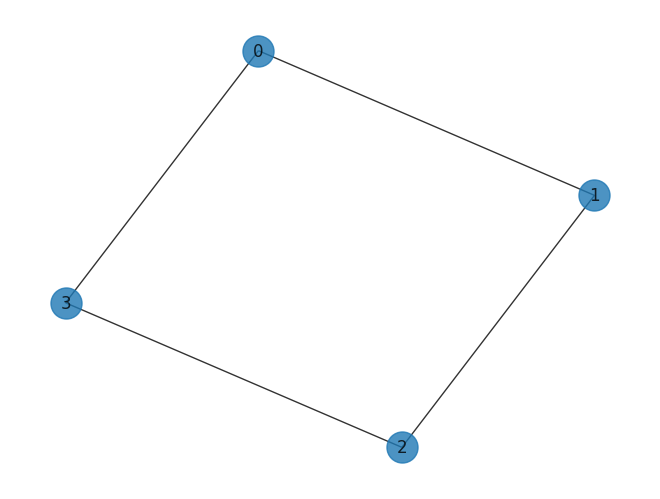

In [ ]:
# The QAOA and the MaxCut problem in a concrete example

import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

n_qb = 4
qubit = QuantumRegister(n_qb)
qc = QuantumCircuit(qubit)

qc.h(qubit)
qc.barrier()

gamma = Parameter("$\\gamma$")
for pair in list(G.edges()):
    qc.rzz(2 * gamma, pair[0], pair[1])

qc.barrier()
beta = Parameter("$\\beta$")
for i in range(0, n_qb):
    qc.rx(2 * beta, i)

qc.measure_all()
qc.draw()

┌───┐ ░                                                    »
  q0_0: ┤ H ├─░──■────────────────■────────────────────────────────»
        ├───┤ ░  │ZZ(2*$\gamma$)  │                                »
  q0_1: ┤ H ├─░──■────────────────┼────────────────■───────────────»
        ├───┤ ░                   │                │ZZ(2*$\gamma$) »
  q0_2: ┤ H ├─░───────────────────┼────────────────■───────────────»
        ├───┤ ░                   │ZZ(2*$\gamma$)                  »
  q0_3: ┤ H ├─░───────────────────■────────────────────────────────»
        └───┘ ░                                                    »
meas: 4/═══════════════════════════════════════════════════════════»
                                                                   »
«                          ░ ┌───────────────┐ ░ ┌─┐         
«  q0_0: ──────────────────░─┤ Rx(2*$\beta$) ├─░─┤M├─────────
«                          ░ ├───────────────┤ ░ └╥┘┌─┐      
«  q0_1: ──────────────────░─┤ Rx(2*$\beta$) ├─░──╫─┤M├──────
«                          ░ ├───────────────┤ ░  ║ └╥┘┌─┐   
«  q0_2: ─■────────────────░─┤ Rx(2*$\beta$) ├─░──╫──╫─┤M├───
«         │ZZ(2*$\gamma$)  ░ ├───────────────┤ ░  ║  ║ └╥┘┌─┐
«  q0_3: ─■────────────────░─┤ Rx(2*$\beta$) ├─░──╫──╫──╫─┤M├
«                          ░ └───────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
«                                                 0  1  2  3

In [ ]:
from scipy.optimize import minimize
from qiskit import transpile
from qiskit_aer import Aer


def cost_function(parameters, qc):
    backend = Aer.get_backend('qasm_simulator')
    bound_qc = qc.assign_parameters({gamma: parameters[0], beta: parameters[1]})
    t_qc = transpile(bound_qc, backend=backend)
    job = backend.run(t_qc, shots=1024)
    counts = job.result().get_counts()
    expectation_value = 0
    for outcome, frequency in counts.items():
        expectation_value += int(outcome, 2) * frequency / 1024
    return expectation_value


initial_point = [0.1, 0.1]
res = minimize(cost_function, initial_point, method='COBYLA', args=(qc))

print("Result:", res.fun)
print("Optimal parameters:", res.x)

Result: 7.2060546875
Optimal parameters: [1.1 0.1]


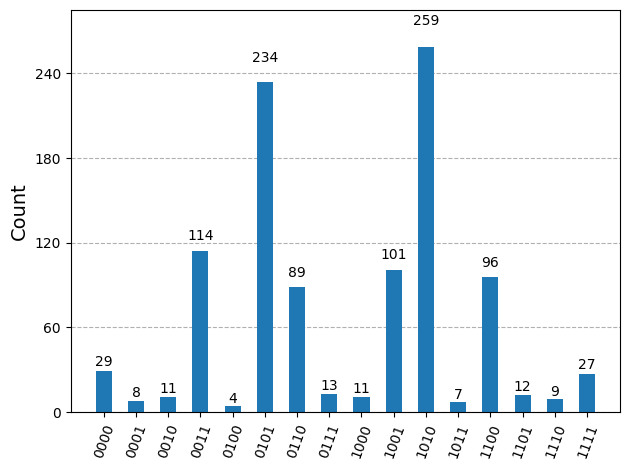

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
bound_qc = qc.assign_parameters({gamma: -0.48489768, beta: 1.91114874})
t_qc = transpile(bound_qc, backend=backend)
job = backend.run(t_qc, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

<a name="ex"></a>
## Exercises

Lets conclude with some exercises.

**Exercise 1.** Prove that it is possible to transform a minimization problem into a maximization problem simply by changing the sign of the objective function. Also, show that a constrained optimization problem can be transformed into an unconstrained one by "embedding" the constraints into the objective function. Specifically, prove that solving  
$$
\min x_1^2 + x_2^2 \quad x \in \Omega = \{x_1 + x_2 - 1 \leq 0, \, x_1 - x_2 = 0\}
$$  
is equivalent to solving (using the [penalty method](https://en.wikipedia.org/wiki/Penalty_method)):  
$$
\min x_1^2 + x_2^2 + a_1 \max(0, x_1 + x_2 - 1)^2 + a_2 (x_1 - x_2)^2 \,.
$$  

**Exercise 2.** If $x \in \mathbb{Z}^n$ is transformed into a binary string $z = z_1 z_2 \dots z_n$ with $z_i = (x_i)_2$, how many binary digits does the string $z$ contain? It is also interesting to note that, by defining $\omega$ as the empty string and the operation $z * w = zw$ between strings as concatenation, one obtains a [monoid](https://en.wikipedia.org/wiki/Monoid). Why is that? This monoid is particularly interesting in algebra due to its relation to [free groups](https://en.wikipedia.org/wiki/Free_group)...  

**Exercise 3.** Prove that in a QUBO problem one can always set $c = 0$. Moreover, show that this constant factor is irrelevant in a quantum computation. Why?  

*Hint:* A QUBO objective function is essentially a paraboloid with binary coordinates.  

**Exercise 4.** Prove that any optimization problem with objective function $f(x) = \langle x | A x \rangle + \langle b | x \rangle$, where $A$ is symmetric and non-degenerate and $x$ is a binary vector, can be reduced to a QUBO problem.

*Hint:* Diagonalize $A$.  

**Exercise 5.** Consider the Ising model in $\mathbb{Z}$ (one-dimensional). Are there equilibrium configurations? If so, which ones?  

**Exercise 6.** Prove that the Ising Hamiltonian $f(\sigma)$ is a quantum observable. Then find a closed-form expression for the associated unitary operator $e^{itf(\sigma)}$, where $t > 0$ is a parameter, and write the Schrödinger equation corresponding to this unitary operator.  

**Exercise 7.** Show that the uniform superposition $H^{\otimes n} |0\rangle^{\otimes n}$ of $n$ qubits initialized in $|0\rangle$, obtained by applying $n$ [Hadamard gates](https://en.wikipedia.org/wiki/Hadamard_matrix) $H$, is the ground state of the mixing unitary $\prod_j e^{i\theta \boldsymbol{\sigma}^{(j)}_x}$.  

**Exercise 8.** Using the provided code as a template, solve the MaxCut problem for a complete graph with $n = 10$ nodes and a number of layers up to $p = 5$. Check your results using [this app](https://quantum-optimization-app.streamlit.app/).


<a name="bib"></a>
## Suggested readings

**[1]** E. Farhi, et al.: [Quantum Computation by Adiabatic Evolution
](https://arxiv.org/abs/quant-ph/0001106) (2000)

**[2]** E. Farhi, et al.: [A Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028) (2014)

**[3]** S. Hadfield, et al.,: [From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz
](https://arxiv.org/abs/1709.03489) (2019)

**[4]** A. M. Semenov et al.,: [Transforming optimization problems into a QUBO form: A tutorial](https://arxiv.org/abs/2410.21074) (2024)

**[5]** F. Glover, et al.,: [A Tutorial on Formulating and Using QUBO Models](https://arxiv.org/abs/1811.11538) (2018)